In [6]:
!pip3 install pysam
!pip3 install polars==0.20

In [7]:
from pysam import FastaFile
dna = FastaFile("../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna")
print(dna.references)
chr_to_references = {
    "1": "CHR1",
    "2": "CHR2",
    "3": "CHR3",
    "4": "CHR4",
    "5": "CHR5",
}
a = dna.fetch(chr_to_references["1"], 0, 1000)

print(dna.get_reference_length(chr_to_references["1"]))


encode_dict = {
    "[mask]": 0,
    "A": 1,
    "C": 2,
    "G": 3,
    "T": 4,
    "Y": 5, # C or T
    "R": 6, # A or G
    "W": 7, # A or T
    "S": 8, # C or G
    "M": 9, # A or C
    "K": 10, # G or T
    "B": 11, # C or G or T
    "D": 12, # A or G or T
    "H": 13, # A or C or T
    "V": 14, # A or C or G
    "a": 1,
    "c": 2,
    "g": 3,
    "t": 4,
    "N": -1,
}

encode_bases = lambda bases: [encode_dict[base] for base in bases]



['CHR1', 'CHR2', 'CHR3', 'CHR4', 'CHR5', 'NC_037304.1', 'NC_000932.1']
30427671


In [8]:
import networkx as nx
import polars as pl

methylome_base_dir = "/mnt/fast/epigenomics/methylome/"

G = nx.DiGraph()

with open(methylome_base_dir + "nodelist.txt") as f:
    nodes = f.read().splitlines()

with open(methylome_base_dir + "edgelist.txt") as f:
    edges = f.read().splitlines()

for node in nodes: 

    if node == "filename,node,gen,meth" or node == "":
        continue

    
    filename, node, gen, meth = node.split(',')
    line = node.split('_')[1]
    
    node = {
        'filename': filename,
        'node': node,
        'line': int(line),
        'gen': int(gen),
        'meth': True if meth == 'Y' else False
    }

    
    G.add_node(node['node'], **node)

for edge in edges:

    if edge == "from to":
        continue

    from_, to_ = edge.split(" ")

    G.add_edge(from_, to_)


for (idx, node) in G.nodes(data=True):
    if node["filename"] != "-":
        df = pl.read_csv(node["filename"], separator="\t", ignore_errors=True).filter(pl.col("seqnames").is_not_nan()).rename({"seqnames": "chromosome"})
        df = df.with_columns(pl.col("status").map_elements(lambda x: 0. if x == "U" else 0.5 if x == "I" else 1.).alias("status_numeric"))
        
    node["sites"] = df

def get_predecessor_node(node):
    if not node in G:
        return None

    pred = iter(G.pred[node])

    if pred.__length_hint__() == 0:
        return None

    pred = G.nodes[next(pred)]

    if pred["meth"]:
        return pred
    else:
        return get_predecessor_node(pred['node'])

def get_pred_node_by_gen_and_line(gen, line):
    pred =  get_predecessor_node(f"{gen}_{line}")
    if pred is None:
        return None, None
    gen, line = pred["node"].split('_')
    return int(gen), int(line)



In [12]:
import numpy as np

embedding_by_chr = {}

for chrsm in range(1, 6):
    print(chrsm)
    data = pl.DataFrame({ "sequence": encode_bases(dna.fetch(chr_to_references[f"{chrsm}"]))})

    # for g in ["gbM", "teM", "UM"]:
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/genes/{g}_gene_anotation_extract_Arabidopsis.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "name", "type", "strand"])
    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)


    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1 if row["strand"] == "+" else -1

    #     s = pl.Series(f"{g}", a)

    #     data = data.with_columns(s)

    # for i in range(1,37):
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/chr_states/At_segments_S{i}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "state"])
    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)
       

    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1

    #     s = pl.Series(f"{i}", a)
      

    #     data = data.with_columns(s)

    # for mod in ["h2az","H3","H3K27Me3","H3K36Me3","H3K4Me1","H3K4Me3","H3K56Ac","input"]:
    #     print(mod)
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/modifications/final/{mod}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end"])

    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)

    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1

    #     s = pl.Series(f"{mod}", a)

    #     data = data.with_columns(s)
       
    embedding_by_chr[chrsm] = data

# display(embedding_by_chr[1])
# display(embedding_by_chr[2])
# display(embedding_by_chr[3])
# display(embedding_by_chr[4])
# display(embedding_by_chr[5])

1
2
3
4
5


In [13]:
for (chrsm, embedding) in embedding_by_chr.items():
    embedding.write_parquet(f"./embeddings/chr_{chrsm}.parquet")

In [14]:
for (chrsm, embedding) in embedding_by_chr.items():
    n = embedding.to_numpy()
    n.tofile(f"./embeddings/chr_{chrsm}.bin")

In [15]:
def steady_state(alpha: float, beta: float):
    pi1 = lambda a, b:  (a * ((1.0 - a) ** 2  - (1.0 - b)**(2) - 1.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0))
    pi2 = lambda a, b:  (4.0 * a * b * (a + b - 2.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0));
    
    return pi1(alpha, beta) + 0.5 * pi2(alpha, beta)



In [37]:
df = G.nodes["0_0"]["sites"]
dfs = df.partition_by("chromosome", as_dict=True)
for (chrsm, df) in dfs.items():
    print(chrsm, df.height)


1 255744
2 136558
3 183790
4 148823
5 225129


In [ ]:
import os
import subprocess
import shutil




def alphabeta(pedigree: nx.DiGraph, chrsm: int, location: int, sites = 100): 
    """
    Run alphabeta-rs to calculate inheritance rates for a specified site in the genome.
    """

    dir = f"./slices/chr:{chrsm}_loc:{location}"
    dir = os.path.abspath(dir)
    if os.path.exists(dir):
        shutil.rmtree(dir)
    
    os.mkdir(dir)

    nodelist = "filename,node,gen,meth\n"
    nodelist += "\n".join([(f"{dir}/{node['node']}.bed" if node['meth'] else "-") + f",{node['node']},{node['gen']},{'Y' if node['meth'] else 'N'}" for (_,node) in pedigree.nodes(data=True)])
    
    open(f"{dir}/nodelist.txt", "w").write(nodelist)

    edgelist = "from,to\n"
    edgelist+= "\n".join([f"{edge[0]},{edge[1]}" for edge in pedigree.edges])
    open(f"{dir}/edgelist.txt", "w").write(edgelist)

    start = 0
    end = 0

    for (_, node) in pedigree.nodes(data=True):
        if node["meth"]:
            df : pl.DataFrame = node["sites"]
            df = df.filter((pl.col("chromosome") == chrsm) & (pl.col("context") == "CG"))
            exists = df.filter(pl.col("start") == location).height
            if exists == 0:
                # print(f"Site at {chrsm}:{location} is not CG.")
                return None, None, None, None, None

            slc = df.bottom_k(sites, by=((pl.col("start") - location ).abs())).sort(["chromosome", "start"])
            start = slc.get_column("start").min()
            end = slc.get_column("start").max()

            if start > location or end < location:
                print(f"Site at {chrsm}:{location} is outside of the closest methylome data.")
                return None, None, None, start, end

            slc.write_csv(f"{dir}/{node['node']}.bed", separator="\t")
    
    
    
    
    if abs(start - end) > 1000:
        print(f"Site at {chrsm}:{location} has far-away neighbours. Closest 100 sites span {abs(start-end)} bp." )

    
    res = subprocess.run(["alphabeta", "-n" ,f"{dir}/nodelist.txt", "-e", f"{dir}/edgelist.txt", "-o", f"{dir}", "-i", "10" ], capture_output=True)
    # print(res.stdout.decode("utf-8"))
    # print(res.stderr.decode("utf-8"))

    model = pl.read_csv(f"{dir}/analysis.txt", separator="\t", has_header=False, new_columns=["key", "value"], n_rows=16, infer_schema_length=16, ignore_errors=True)
    alpha = model.filter(pl.col("key") == "Alpha").get_column("value").max()
    beta = model.filter(pl.col("key") == "Beta").get_column("value").max()
    std_st = steady_state(alpha, beta)
   
    shutil.rmtree(dir)
    return alpha, beta, std_st, start, end



alphabeta(G, 1, 3189)
alphabeta(G, 1, 23189)


Site at 1:23189 has far-away neighbours. Closest 100 sites span 1934 bp.


(0.0015526179819283846,
 0.0031381189232310815,
 0.3309966031607142,
 23151,
 25085)

In [ ]:
rows = []

for i in range(embedding_by_chr[1].height):
    alpha, beta, std_st, start, end =  alphabeta(G, 1, i)
    # print(i, alpha, beta, std_st, start, end)
    rows.append((1,i, start, end, alpha, beta, std_st))

    if i % 1000 == 0:
        print(i)
        targets = pl.DataFrame(rows,schema = ["chromosome", "location", "start", "end", "alpha", "beta", "steady_state"], orient="row")
        # display(targets)
        targets.write_parquet("./embeddings/targets.parquet")

targets = pl.DataFrame(rows,schema = ["chromosome", "location", "start", "end", "alpha", "beta", "steady_state"], orient="row")
targets.write_parquet("./embeddings/targets.parquet")
display(targets)




chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


KeyboardInterrupt: 

In [ ]:
# There must be a subtle bug here because the rates are around 13x too high
def dT(i, j):
    gen_i, line_i = i.split('_')
    gen_j, line_j = j.split('_')

    if line_i != line_j: # Latest common ancestor is the root node
        return int(gen_i) + int(gen_j)
    else:
        return int(gen_j) - int(gen_i)

res_gain = pl.DataFrame()
res_loss = pl.DataFrame()
divergence = pl.DataFrame()
locations = G.nodes["0_0"]["sites"].get_column("start")
display(locations)
dTs = {}
pairs = [(i, j, dT(i,j), node_i["gen"], node_j["gen"], node_i["sites"].get_column("status_numeric"), node_j["sites"].get_column("status_numeric")) for (i, node_i) in G.nodes(data=True) for (j, node_j) in G.nodes(data=True) if (node_j["gen"] > node_i["gen"] or (node_j["gen"] == node_i["gen"]  and node_j["line"] > node_i["line"]))  and node_i["meth"] and node_j["meth"]]
for p in pairs:
        i,j , dT, gen_i, gen_j, states_i, states_j = p
        
        div = (states_j - states_i)
        
        
        gain = div.clip(lower_bound=0)
        loss = div.clip(upper_bound=0).abs()
        joined = pl.DataFrame({"i": states_i, "j": states_j, "diff": div.abs(), "gain": gain, "loss": loss})
        # print(i, j, dT)
        # display(joined[11200:])

        res_gain = res_gain.with_columns(gain.alias(f"{i}:{j}"))
        res_loss = res_loss.with_columns(loss.alias(f"{i}:{j}"))
        divergence = divergence.with_columns(div.abs().alias(f"{i}:{j}"))
        dTs[f"{i}:{j}"] = dT
        # print(i, j, dT, gen_i, gen_j)

# build Dataframe from dTs
dTs = pl.DataFrame([pl.Series("pairs" ,dTs.keys()), pl.Series("dT", dTs.values())] )
alpha_for_all_sites  = res_gain.mean_horizontal()
beta_for_all_sites = res_loss.mean_horizontal()
divergence_rolling = divergence.mean_horizontal().rolling_mean(1000)
divergence = divergence.mean()
divergence_over_time = dTs.hstack(divergence.transpose()).sort("dT")
display(divergence_over_time)
print(alpha_for_all_sites.mean() , beta_for_all_sites.mean())


start
i64
23151
23152
23180
23181
23188
23189
23296
23297
23337


pairs,dT,column_0
str,i64,f64
"""0_0:1_2""",1,0.02706
"""0_0:1_8""",1,0.03028
"""1_2:2_2""",1,0.026898
"""1_8:2_8""",1,0.021645
"""4_2:5_2""",1,0.02662
"""4_8:5_8""",1,0.022702
"""0_0:2_2""",2,0.023537
"""0_0:2_8""",2,0.031037
"""1_2:1_8""",2,0.027545


0.01649841949321116 0.017083439609481277


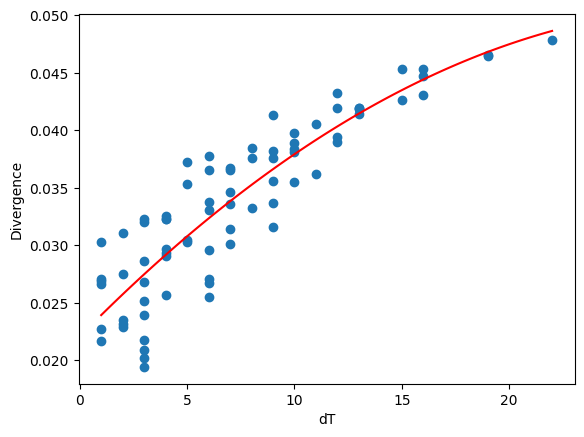

In [ ]:
# scatter plot of divergence over time
import matplotlib.pyplot as plt

plt.plot(divergence_over_time["dT"].to_numpy(), divergence_over_time["column_0"].to_numpy(), 'o')

plt.xlabel("dT")
plt.ylabel("Divergence")

#include line of best fit
import numpy as np

X = divergence_over_time["dT"].to_numpy()
y = divergence_over_time["column_0"].to_numpy()

p = np.polyfit(X, y, 2)
x = np.linspace(min(X), max(X), num=78)


plt.plot(x, np.poly1d(p)(x), color='red')

plt.show()


[       nan        nan        nan ... 0.02087179 0.02087179 0.02087179]


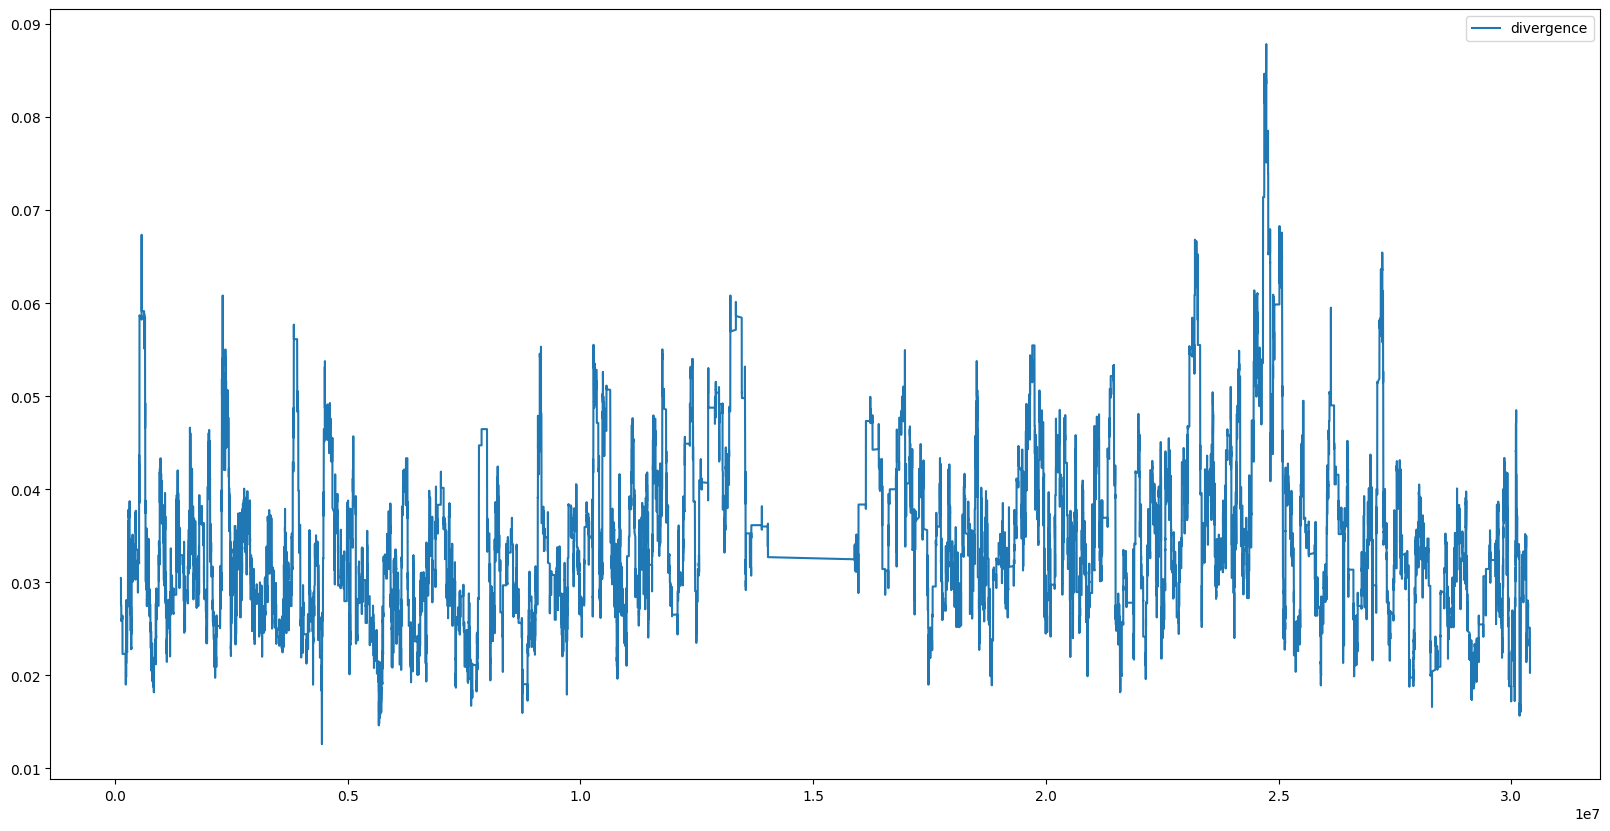

In [ ]:
# take rolling average, reduce to 1/10000th of the size, then plot
sites_div = pl.DataFrame({"location": locations, "divergence": divergence_rolling})
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
print(divergence_rolling.to_numpy())
plt.plot(locations.to_numpy(), divergence_rolling.to_numpy(), label="divergence")

plt.legend()



In [ ]:
from pysam import FastxFile

with FastxFile('../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna') as dna:
    for entry in dna:
        print(entry.name, entry.comment, entry.sequence[:10], sep='\n')


NC_003070.9
Arabidopsis thaliana chromosome 1 sequence
ccctaaaccc
NC_003071.7
Arabidopsis thaliana chromosome 2, partial sequence
NNNNNNNNNN
NC_003074.8
Arabidopsis thaliana chromosome 3, partial sequence
NNNNNNNNNN
NC_003075.7
Arabidopsis thaliana chromosome 4, partial sequence
NNNNNNNNNN
NC_003076.8
Arabidopsis thaliana chromosome 5, partial sequence
TATACCATGT
NC_037304.1
Arabidopsis thaliana ecotype Col-0 mitochondrion, complete genome
AGAGGTCAGA
NC_000932.1
Arabidopsis thaliana chloroplast, complete genome
ATGGGCGAAC
